In [1]:
import os
os.chdir("/Users/users/lourens/RDMP/master_research/code/SGQ_classification/")

# Training a Neural Network to emulate SDR applied to the CPz catalog
The code in this notebook will demonstrate how I trained a neural network to emulate SDR applied to the CPz catalog resulting in a SDR-NNP (sharpened dimensionality reduction with neural network projections) model. The purpose of this model is to allow our pipeline to work with unseen data in a scalable way (i.e. we don't need to rerun SDR on the full dataset each time new data arrives). Again we will only apply this to the STAR dataset projected with sharpened LMDS for the sake of demonstration.

## Imports

In [2]:
import numpy as np
from astropy.table import Table

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from SHARC.plot_funcs import plot_projection

from SHARC.nn_models import construct_NNPModel
from SHARC.nn_training_utils import train_nnp
from SHARC.loss_functions import MedianAbsoluteError, MedianSquaredError

# colors used for different classifiers in HDBSCAN paper
colors_STAR = ["Kmag-Y3mag", "Kmag-J3mag", "Kmag-Z3mag", "Kmag-H3mag", "J3mag-K3mag",
               "Y3mag-K3mag", "J3mag-W1mag", "Y3mag-W1mag", "Jmag-Kmag", "H3mag-K3mag",
               "H3mag-W1mag", "Ymag-Kmag", "Hmag-Y3mag", "Y3mag-W2mag", "J3mag-W2mag",
               "imag-g3mag", "Z3mag-W1mag", "Z3mag-K3mag", "zmag-u3mag", "Hmag-J3mag"] # from Table 3 (italics, i.e. colours only)

method = "LMDS"
method_path = os.path.join("/rdmp_data/users/lourens/master_research/data/HDBSCAN2/STAR", method)

seed = 42

2023-02-10 18:31:32.935607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 18:31:32.935706: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading SDR results
Remember that running the code in `CPz_SDR_optimization.ipynb` saved the result of projecting with the optimal DR and LGC parameters to the `CPz_STAR_dataset.fits.gz` file. Therefore, we can simply load the table from this file and use it to train and test our neural network.

Note that the embedding data `Y` gets normalized between 0 and 1. This is to match the output activation of the neural network (i.e. sigmoid) which can only yield values between 0 and 1. We also  split the full dataset into a training and test set. This is such that we can evaluate the performance of the neural network on a dataset it hasn't seen during the training phase. For the test set we will use 20% of the full dataset and we ensure that both the training and test set have the same relative class frequencies by stratifying with respect to the object labels.

In [14]:
# load fits table
table = Table.read("/rdmp_data/users/lourens/master_research/data/HDBSCAN2/STAR/CPz_STAR_dataset.fits.gz", format="fits")
display(table)
table = table.to_pandas()

# extract input features (X), output features (Y) and labels from the table
X = table[colors_STAR].values
Y = table[[f"Y_S{method}1", f"Y_S{method}2"]].values
labels = table[["Hclass"]].values.ravel()
print(X.shape, Y.shape, labels.shape)

# preprocess output features such that values lie between 0 and 1
scaler = MinMaxScaler()
Y = scaler.fit_transform(Y)

# split data into training and test sets
test_size = 0.2
X_train, X_test, Y_train, Y_test, labels_train, labels_test = train_test_split(X, Y, labels, test_size=test_size, shuffle=True, stratify=labels, random_state=seed)
print(X_train.shape, Y_train.shape, labels_train.shape)
print(X_test.shape, Y_test.shape, labels_test.shape)

id,RAdeg,DEdeg,z,Hclass,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Ymag,e_Ymag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,W1mag,e_W1mag,W2mag,e_W2mag,u3mag,e_u3mag,g3mag,e_g3mag,r3mag,e_r3mag,i3mag,e_i3mag,Z3mag,e_Z3mag,Y3mag,e_Y3mag,J3mag,e_J3mag,H3mag,e_H3mag,K3mag,e_K3mag,Yhlr,Jhlr,Hhlr,Khlr,PCAs1c,PCAs2c,PCAs3c,PCAg1c,PCAg2c,PCAg3c,PCAq1c,PCAq2c,PCAq3c,ClasscO,CassscA,dpc,Poutc,Pstarc,Pgalc,Pqsoc,Labelc,PCAs1cHLR,PCAs2cHLR,PCAs3cHLR,PCAg1cHLR,PCAg2cHLR,PCAg3cHLR,PCAq1cHLR,PCAq2cHLR,PCAq3cHLR,ClasscHLRO,ClasscHLRA,dpcHLR,PoutcHLR,PstarcHLR,PgalcHLR,PqsocHLR,LabelcHLR,Kmag-Y3mag,Kmag-J3mag,Kmag-Z3mag,Kmag-H3mag,J3mag-K3mag,Y3mag-K3mag,J3mag-W1mag,Y3mag-W1mag,Jmag-Kmag,H3mag-K3mag,H3mag-W1mag,Ymag-Kmag,Hmag-Y3mag,Y3mag-W2mag,J3mag-W2mag,imag-g3mag,Z3mag-W1mag,Z3mag-K3mag,zmag-u3mag,Hmag-J3mag,Y_LMDS1,Y_LMDS2,Y_SLMDS1,Y_SLMDS2
,deg,deg,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,arcsec,arcsec,arcsec,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes24,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32
0104-00119,34.41787,-4.72127,0.72559,1,23.4122,0.0505,22.8534,0.0211,22.2006,0.0206,21.3921,0.0125,20.9957,0.0205,20.942,0.1872,21.307,0.8141,20.6116,0.4225,20.0746,0.2015,19.2583,0.071,20.1558,0.305,23.6573,0.0413,23.1494,0.0175,22.5104,0.017,21.6177,0.0097,21.3693,0.0174,20.9169,0.1349,21.2552,0.6533,20.4513,0.3581,19.7707,0.1487,0.75589,0.64208,0.66781,0.62961,-1.15732,-2.11252,0.26002,-1.11161,-0.27282,-0.44797,-1.06384,-0.26909,-0.42575,2,2,0,0.0,0.0,1.0,0.0,2,-1.45773,-0.82213,0.18082,-1.4632,-0.16978,0.00834,0.97244,-0.09133,-0.75841,2,2,0,0.0,0.0,0.99,0.01,2,-0.842299999999998,-1.1805999999999983,-1.2946999999999989,-0.3766999999999996,1.484499999999997,1.1461999999999968,1.9969000000000001,1.6585999999999999,1.2323999999999984,0.6805999999999983,1.1930000000000014,0.8674,-0.305299999999999,0.761099999999999,1.0993999999999993,-1.7573000000000008,2.1110000000000007,1.5985999999999976,-2.6616,-0.6435999999999993,-0.265632,0.508555,0.157402,0.386511
0104-00184,34.37192,-4.59308,0.44925,1,22.018,0.0229,21.3995,0.0088,20.4452,0.0065,19.9624,0.0057,19.8319,0.0107,19.6647,0.0713,19.6658,0.2254,19.1885,0.1735,19.0394,0.1412,19.3925,0.08,19.8699,0.244,22.5703,0.0175,21.9737,0.0065,21.0491,0.005,20.5636,0.0044,20.4156,0.0074,19.931,0.0653,19.8437,0.1613,19.5163,0.1552,19.3704,0.1149,1.04066,0.92622,1.00097,1.0041,-0.19838,-0.40535,0.55346,-0.03172,-0.20366,0.13045,-0.02409,-0.20295,0.13825,2,2,0,0.0,0.0,1.0,0.0,2,-0.02468,0.10831,0.1801,-0.03298,0.12811,0.17348,0.07296,0.04991,-0.26422,2,2,0,0.0,0.0,1.0,0.0,2,-0.8916000000000004,-0.8042999999999978,-1.3762000000000008,-0.47690000000000055,0.4732999999999983,0.5606000000000009,0.45120000000000005,0.5385000000000026,0.6264000000000003,0.14590000000000103,0.1238000000000028,0.6252999999999993,-0.7424999999999997,0.06109999999999971,-0.026200000000002888,-2.011300000000002,1.023100000000003,1.0452000000000012,-2.7383999999999986,-0.6551999999999971,-0.0181035,0.0827304,0.0220367,0.0555632
0104-00227,34.41814,-4.5809,0.699164,1,22.4891,0.0389,21.7992,0.0141,21.0215,0.012,20.06

(48686, 20) (48686, 2) (48686,)
(38948, 20) (38948, 2) (38948,)
(9738, 20) (9738, 2) (9738,)


## Training Neural Network
Now its time to train a neural network. The neural network we will use is defined in `nn_models.py` and uses `NNPModelBackboneV2` as its backbone. To construct it we simply have to call the `construct_NNPModel` function with `version=2`.

In [15]:
model = construct_NNPModel(X_train.shape[1], output_dimensions=2, output_activation="sigmoid", version=2, D1_units=X_train.shape[1], rate=0, momentum=0.6)
display(model.summary())

Model: "NNPModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 nnp_model_backbone_v2_1 (NN  (None, 5)                1240      
 PModelBackboneV2)                                               
                                                                 
 dense_11 (Dense)            (None, 2)                 12        
                                                                 
Total params: 1,252
Trainable params: 1,138
Non-trainable params: 114
_________________________________________________________________


None

In order to train the neural network I implemented a convenient function called `train_nnp` which can be used as follows:

In [16]:
epochs = 20000
validation_ratio = 0.25
loss_function = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(1e-3)
train_loss, valid_loss, pred_train_loss = train_nnp(X_train, Y_train, model, loss_function, optimizer, labels=labels_train, epochs=epochs, validation_ratio=validation_ratio, save_path=method_path)

Time for epoch 100 is 0.11376070976257324 sec. Loss: 0.034183, Inference loss: 0.033613, Validation loss: 0.033609
Time for epoch 200 is 0.11496233940124512 sec. Loss: 0.018831, Inference loss: 0.018808, Validation loss: 0.018864
Time for epoch 300 is 0.11477804183959961 sec. Loss: 0.017162, Inference loss: 0.017161, Validation loss: 0.017263
Time for epoch 400 is 0.11475992202758789 sec. Loss: 0.016461, Inference loss: 0.016457, Validation loss: 0.016535
Time for epoch 500 is 0.11513471603393555 sec. Loss: 0.015988, Inference loss: 0.015978, Validation loss: 0.016111
Time for epoch 600 is 0.1160440444946289 sec. Loss: 0.015684, Inference loss: 0.015682, Validation loss: 0.015643
Time for epoch 700 is 0.11756587028503418 sec. Loss: 0.015456, Inference loss: 0.015447, Validation loss: 0.015416
Time for epoch 800 is 0.11720657348632812 sec. Loss: 0.015288, Inference loss: 0.015287, Validation loss: 0.015240
Time for epoch 900 is 0.11802148818969727 sec. Loss: 0.015174, Inference loss: 0.

The training function uses cross validation to prevent overfitting. In this case we use 25% of the training set for validation at each epoch. Furthermore, the training function stores checkpoints every 100 training epochs in a temporary folder inside the directory specified by `save_path` such that whenever something goes wrong one can simply reload the model from the checkpoint and continue training. Additional information such as training loss, validation loss etc. are stored in a file called `training_history.npz` which will also be stored as checkpoints in the same directory. Once fully trained the model and training history file are saved in a folder with the name of the model in the `save_path`.

I also implemented a number of loss functions myself which can be found in `loss_functions.py`. However, I found that generally `tf.keras.losses.MeanAbsoluteError()` works best.

## Testing Neural Network
Now that the neural network has been trained we can test it and check whether it has not overfitted on the training data by comparing the testing loss to the training loss. We can also inspect the projection results and the training and validation loss curves to see whether our neural network has been properly optimized. See below for a figure summarizing these results.

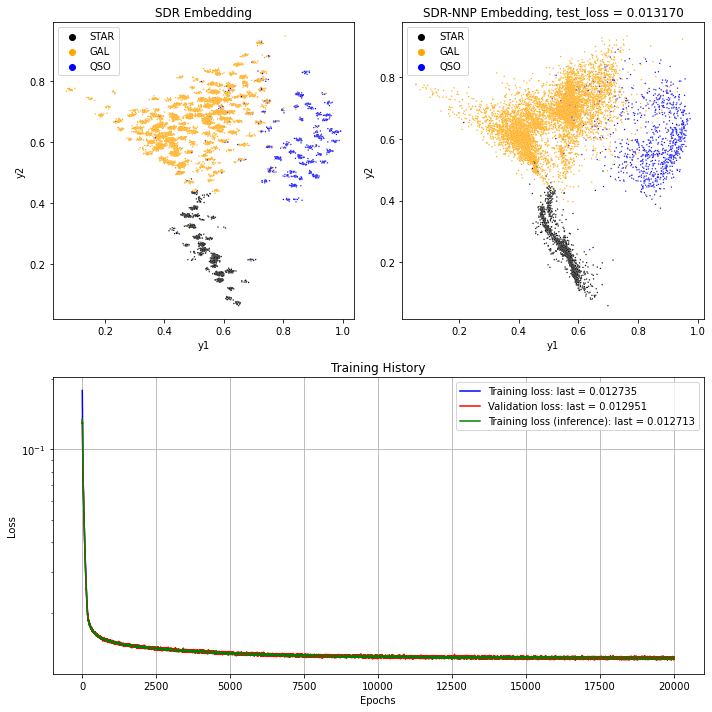

In [18]:
# model = tf.keras.models.load_model(os.path.join(method_path, "NNPModel")) # load saved model

Y_pred = model(X_test, training=False)

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

ax1.set_title("SDR Embedding")
plot_projection(Y_test, labels=labels_test, ax=ax1)

ax2.set_title("SDR-NNP Embedding, test_loss = {:.6f}".format(loss_function(Y_test, Y_pred)))
plot_projection(Y_pred, labels=labels_test, ax=ax2)

ax3.set_title("Training History")
ax3.plot(range(1,len(train_loss) + 1), train_loss, c="blue", label="Training loss")
ax3.plot(range(1,len(train_loss) + 1), valid_loss, c="red", label="Validation loss")
ax3.plot(range(1,len(train_loss) + 1), pred_train_loss, c="green", label="Training loss (inference)")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss")
ax3.set_yscale("log")

h, l = ax3.get_legend_handles_labels()
l = [": ".join([label, "last = {:.6f}".format(loss[-1])]) for label, loss in zip(l, [train_loss, valid_loss, pred_train_loss])]

ax3.legend(handles=h, labels=l)
ax3.grid()

fig.tight_layout()

fig.savefig(os.path.join(method_path, model.name, "NNP_test.png"), dpi=fig.dpi)

plt.show()

See below for a projection of the full dataset:

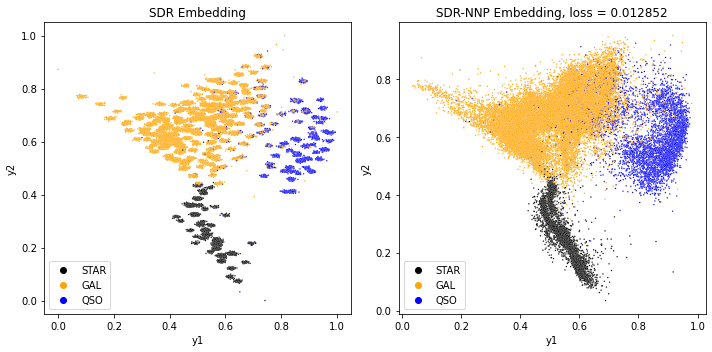

In [20]:
Y_pred = model(X, training=False)

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1.set_title("SDR Embedding")
plot_projection(Y, labels=labels, ax=ax1)

ax2.set_title("SDR-NNP Embedding, loss = {:.6f}".format(loss_function(Y, Y_pred)))
plot_projection(Y_pred, labels=labels, ax=ax2)

fig.tight_layout()

fig.savefig(os.path.join(method_path, model.name, "NNP_full.png"), dpi=fig.dpi)

plt.show()